In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import statsmodels
import sklearn
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

## 1.0 Loading Datasets

In [3]:
df = pd.read_excel("superstore.xls")
supplies = df.loc[df['Category'] == 'Office Supplies']

In [4]:
supplies

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,9983,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,OFF-PA-10002195,Office Supplies,Paper,"RSVP Cards & Envelopes, Blank White, 8-1/2"" X ...",35.560,7,0.0,16.7132
9984,9985,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-LA-10003766,Office Supplies,Labels,Self-Adhesive Removable Labels,31.500,10,0.0,15.1200
9985,9986,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-SU-10000898,Office Supplies,Supplies,Acme Hot Forged Carbon Steel Scissors with Nic...,55.600,4,0.0,16.1240
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200


## 2.0 Data Preprocessing

In [5]:
supplies_sales = supplies.drop(columns=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
                                        'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category'
                                        , 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit'])

In [6]:
supplies_sales= supplies_sales.sort_values('Order Date')
supplies_sales

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784
741,2014-01-04,3.540
1759,2014-01-05,19.536
...,...,...
5091,2017-12-30,3.024
1297,2017-12-30,20.720
908,2017-12-30,52.776
1296,2017-12-30,13.904


In [7]:
supplies_sales.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
supplies_sales = supplies_sales.groupby('Order Date')['Sales'].sum()
supplies_sales = supplies_sales.reset_index()

In [9]:
supplies_sales = supplies_sales.set_index('Order Date')


In [10]:
supplies_sales = supplies_sales['Sales'].resample('MS').mean()

In [11]:
supplies_sales

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504187
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

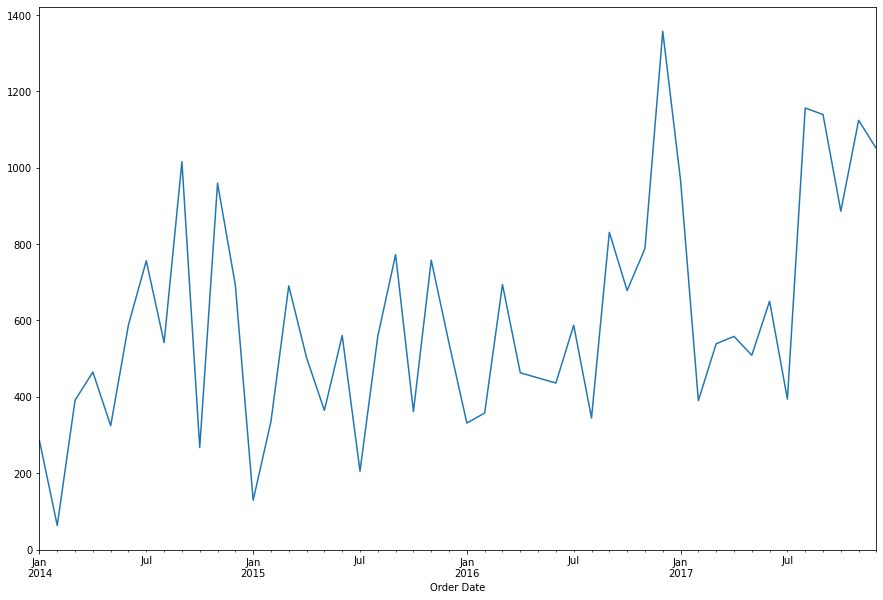

In [12]:
supplies_sales.plot(figsize=(15, 10))
plt.show()

<Figure size 1080x720 with 0 Axes>

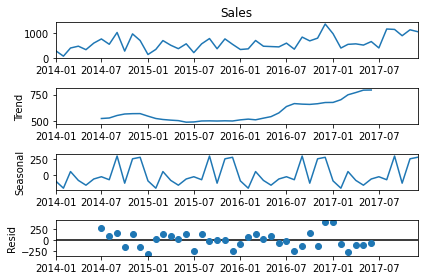

In [13]:
decomposition = seasonal_decompose(supplies_sales, model = "add")
plt.figure(figsize = (15,10))
decomposition.plot();

## 3.0 Building Model

### 3.1 Fitting ARIMA Model

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model_ARIMA = sm.tsa.statespace.SARIMAX(supplies_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model_ARIMA.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:747.1990404227043
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1591.6939914514762
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:500.7335398750499
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:333.71014965104536
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936834
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1345.1104898904828
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:335.9078573355862
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292506
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2734.1772573355347
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.7601415814754
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:319.8625957279695
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646587392
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2564.1855583680826
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.6922094460088
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:320.845077528205
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:666.4572045007284
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1239.1520347079631
ARIM

As ARIMA(0, 1, 1)x(0, 1, 1, 12)12 has an AIC of 302.48, which is the lowest AIC. Therefore, we will take this as the optimal option.

In [16]:
model_ARIMA = sm.tsa.statespace.SARIMAX(supplies_sales,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results = model_ARIMA.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8436      0.117     -7.239      0.000      -1.072      -0.615
ma.S.L12      -1.0001      0.201     -4.978      0.000      -1.394      -0.606
sigma2      4.502e+04   4.46e-06   1.01e+10      0.000     4.5e+04     4.5e+04


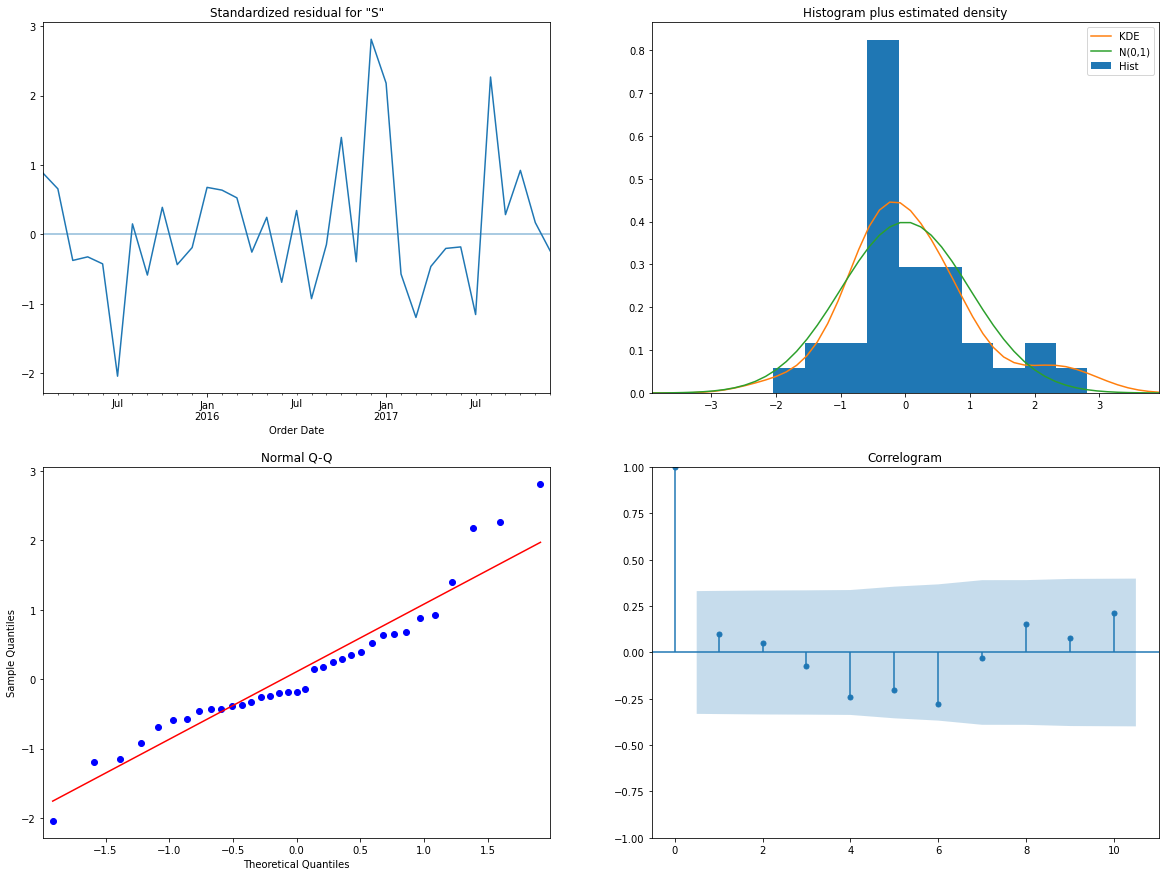

In [17]:
results.plot_diagnostics(figsize=(20, 15))
plt.show()

### 3.2 Model Validation

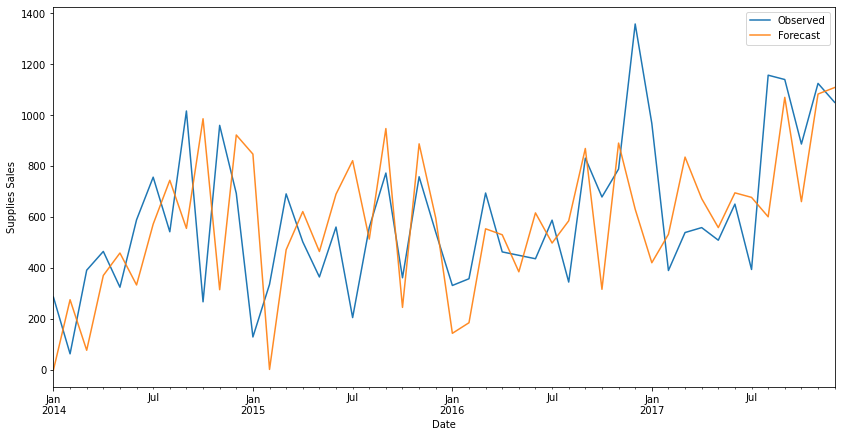

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = supplies_sales['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Supplies Sales')
plt.legend()
plt.show()

In [19]:
sales_forecasted = pred.predicted_mean
sales_truth = supplies_sales['2014-01-01':]

rmse = rmse(sales_truth,sales_forecasted)
mse = rmse**2

In [20]:
print('The Mean Squared Error of our forecasts is', mse)
print('The Root Mean Squared Error of our forecasts is', rmse)

The Mean Squared Error of our forecasts is 93416.07703051568
The Root Mean Squared Error of our forecasts is 305.64043749235094


## 4.0 Forecasting Sales

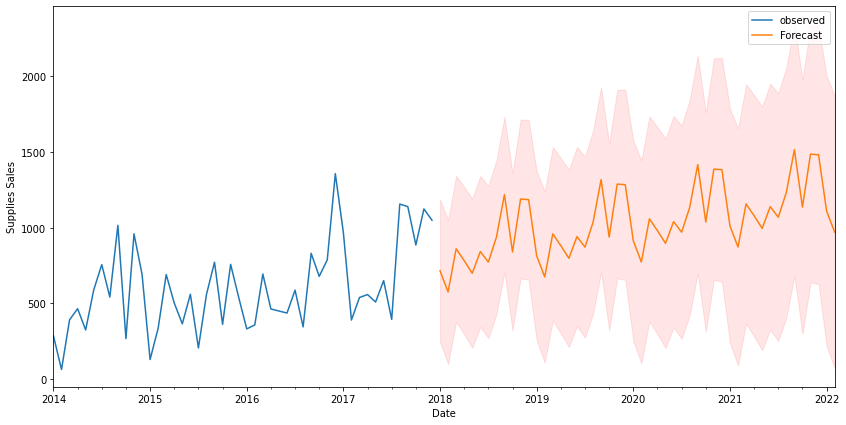

In [21]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = supplies_sales.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Supplies Sales')
plt.legend()
plt.show()

## 5.0 Save the Model

In [22]:
pickle.dump(results, open('model.pkl','wb'))

## 6.0 Load the Model

In [23]:
model = pickle.load(open('model.pkl','rb'))

### 6.1 Forecasting 1 Year Ahead 

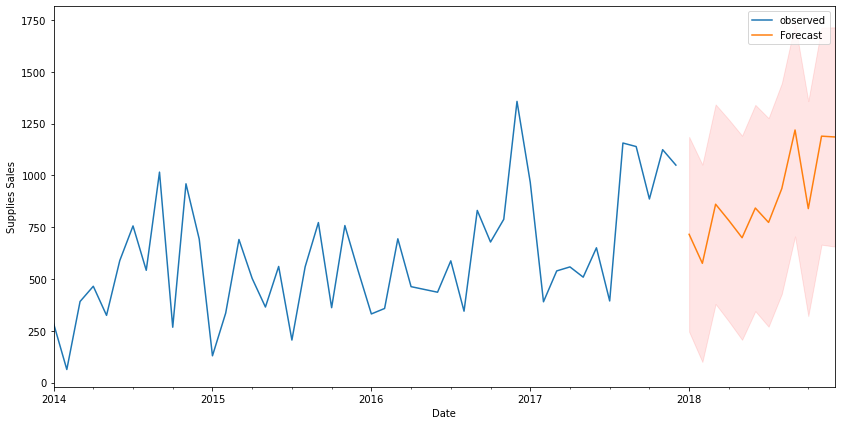

In [24]:
pred_uc = model.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = supplies_sales.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Supplies Sales')
plt.legend()
plt.show()